### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ №8

#### Дисциплина: Интеллектуальный анализ данных

##### Студент:  Николаев Александр Викторович
##### Группа:   НФИбд-01-17

## Москва 2020
***

### Вариант №23

Coil 1999 Competition Data Data Set  

Название файла: analysis.data 

Ссылка: http://archive.ics.uci.edu/ml/datasets/Coil+1999+Competition+Data  

Предиктор: столбец No 4 

Зависимая переменная: столбец No 5 

Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

Считываем данные

In [2]:
# read data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/coil-mld/analysis.data', header=None)
data = data.iloc[:, [3, 4]]

# drop rows with XXXXXX values
data.drop(index=data[(data == 'XXXXXXX').any(axis=1)].index, inplace=True)

# rename columns
data.columns = ['x', 'y']

# change dtype to float
for col in data.columns:
    data[col] = data[col].astype(float)
    
# show data
data

,x,y
0,8.00,9.8
1,8.35,8.0
2,8.10,11.4
3,8.07,4.8
4,8.06,9.0
...,...,...
195,8.40,8.4
196,8.30,10.6
197,8.20,7.0
198,8.00,7.6


In [3]:
data.isna().sum() + (data == '?').sum()

x    0
y    0
dtype: int64

Пропусков нет.

Масштабируем переменные на отрезок [0, 1] с помощью MinMaxScaler

In [4]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [5]:
x = data[:, 0].reshape(-1, 1)
y = data[:, 1]

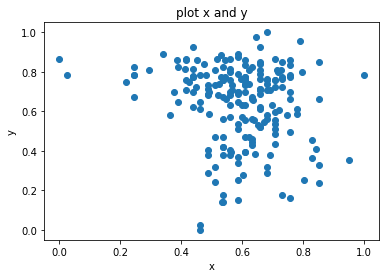

In [6]:
plt.title('plot x and y')
plt.ylabel('y')
plt.xlabel('x')
plt.scatter(x, y);

По ощущениям слабая корреляция между независимой и зависимой переменной, поэтому хорошей модели построить не получится по одному предиктору. Возможно, полиномиальные фичи дадут прирост.

Разобьём данные на трейн и тест

In [7]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

Построим регрессоры на основе:
- линейной регрессии (LinearRegression)
- полиномиальной регрессии (PolynomialFeatures+LinearRegression)
- стохастического градиентного спуска (SGDRegressor)
- гребневой регрессии (Ridge)
- лассо регрессии (Lasso)
- регрессии эластичная сеть (ElasticNet)
- регрессии на основе метода ближайших соседей (KNeighborsRegressor)
- регрессии на основе деревьев решений (DecisionTreeRegressor)
- регрессии на основе метода опорных векторов (SVR)

In [8]:
degree = 2
lr = LinearRegression()
plr = Pipeline([
    ('poly', PolynomialFeatures(degree)),
    ('scaler', StandardScaler()),
    ('LR', LinearRegression())])
sgd = SGDRegressor()
ridge = Ridge()
lasso = Lasso()
enet = ElasticNet()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()
svm = SVR()

models = [lr, plr, sgd, ridge, lasso, enet, knn, tree, svm]
names = ['Linear Regression', 'Polynomial Regression', 'SGDRegression', 'Ridge',
        'Lasso', 'ElasticNet', 'KNNRegression', 'DecisionTreeRegression', 'SVM']

In [9]:
preds = []
scores = []
for model in models:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    score = r2_score(y_test, pred)
    
    preds.append(preds)
    scores.append(score)

In [10]:
for score, name in sorted(zip(scores, names), reverse=True):
    print(f'{name:^30} R^2 SCORE = {score}')

             SVM               R^2 SCORE = 0.0313412358925681
    Polynomial Regression      R^2 SCORE = 0.018245999434477023
            Ridge              R^2 SCORE = 0.010545222362461804
      Linear Regression        R^2 SCORE = 0.006664661849033582
            Lasso              R^2 SCORE = -0.00023620926624179361
          ElasticNet           R^2 SCORE = -0.00023620926624179361
        SGDRegression          R^2 SCORE = -0.06775503345593159
        KNNRegression          R^2 SCORE = -0.09634853525955478
    DecisionTreeRegression     R^2 SCORE = -0.3678804819498167


Подберем параметры для каждой модели кроме LR

In [11]:
# задаем сетку для каждой модели
params_poly = {'poly__degree': [deg for deg in range(2, 11)]}
params_sgd = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l1', 'l2', 'elasticnet'],}
params_ridge = {
    'fit_intercept': [True, False],
    'alpha': [i / 1000 for i in range(1, 100001, 200)]}
params_lasso = {
    'fit_intercept': [True, False],
    'alpha': [i / 1000 for i in range(1, 100001, 200)]}
params_enet = {
    'fit_intercept': [True, False],
    'alpha': [i / 1000 for i in range(1, 10001, 500)],
    'l1_ratio': [i / 1000 for i in range(1, 10001, 500)]}
params_knn = {
    'n_neighbors': [i for i in range(1, 31)],
    'weights': ['uniform', 'distance'],
    'p': [0.5, 1, 2, 3]}
params_tree = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'min_samples_leaf': [i for i in range(1, 11)]}
params_svm = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Будем фитить на трейне только.
params_models = [params_poly, params_sgd, params_ridge, params_lasso, params_enet, params_knn, params_tree, params_svm]
best_models = [LinearRegression().fit(x_train, y_train)]
for model, params in zip(models[1:], params_models):
    clf = GridSearchCV(model, params, scoring='r2', cv=5)
    clf.fit(x_train, y_train)
    best_models.append(clf.best_estimator_)

Нарисуем результаты.

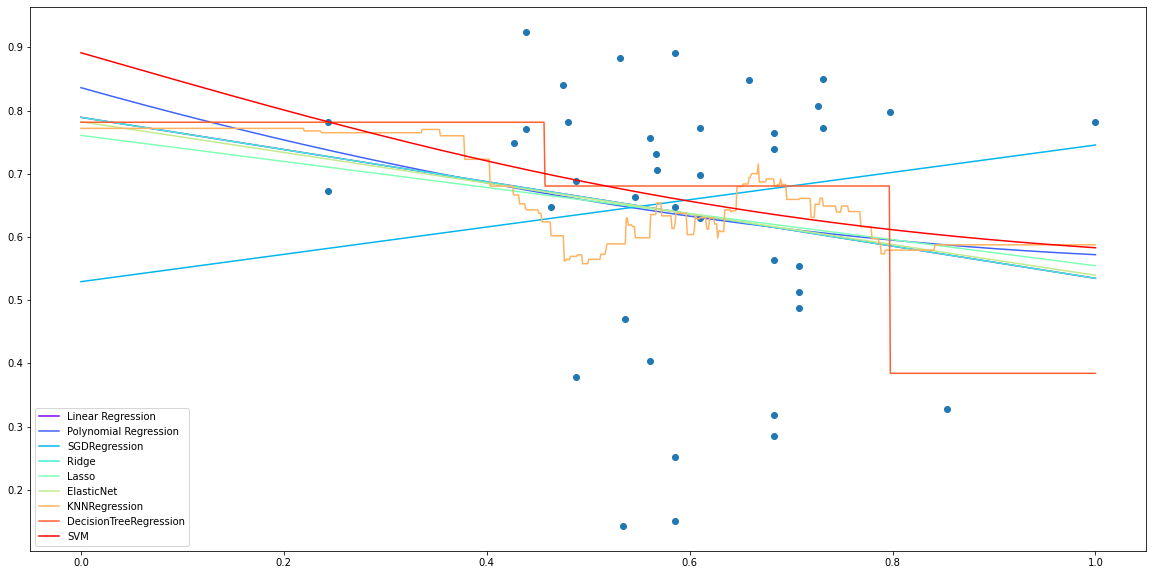

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(x_test, y_test)
x_space = np.linspace(0, 1, 1000).reshape(-1, 1)
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(best_models))))
for model, name in zip(best_models, names):
    c = next(color)
    y_pred = model.predict(x_space)
    plt.plot(x_space, y_pred, c=c, label=name)
plt.legend()
plt.show()

Посчитаем $R^2$ на отложенной выборке и выберим наилучший эстиматор.

In [13]:
scores_of_best = [r2_score(y_test, best_model.predict(x_test)) for best_model in best_models]
for score, name in sorted(zip(scores_of_best, names), reverse=True):
    print(f'{name:^30} R^2 SCORE = {score}')

    Polynomial Regression      R^2 SCORE = 0.018245999434477023
        KNNRegression          R^2 SCORE = 0.010354218644382684
            Lasso              R^2 SCORE = 0.010060334736222698
          ElasticNet           R^2 SCORE = 0.007695316884713366
            Ridge              R^2 SCORE = 0.006671955300546539
      Linear Regression        R^2 SCORE = 0.006664661849033582
             SVM               R^2 SCORE = -0.00042561306302735247
    DecisionTreeRegression     R^2 SCORE = -0.03271709809891554
        SGDRegression          R^2 SCORE = -0.06463214573449139


Лучшим на тесте оказалась полиномиальная регрессия.
Вторым по результатам оказался KNN (метод ближайших соседей). Что на самом деле очень логично, т.к. точки на плоскости по сути представляют собой плотное облоко и довольно логично было бы делать предсказание на основе ближайших точек, в силу как раз плотности.